# 人工晶体度数计算中的参数估计与优化

发现了一篇[Determination of Personalized IOL-Constants for the Haigis Formula under Consideration of Measurement Precision](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0158988)

里面讲的是使用加权最小二乘法来进行Haigis公式的参数优化。我打算使用他的数据，而利用贝叶斯方法做同样的事情。练会这一招以后，其他IOL计算公式的参数优化也是一样的。

# 获得数据

必须得说，临床医学的公开数据比起做计算机的，真是少多了。除了哪些有机器学习强力推动的图像数据集，要找一个开放的数据集还真是困难，虽然理论上，不过就是白内障术前测量和术后复查的IOL数据，好像一抓一大把。但术后IOL稳定至少要3个月，国内的白内障病人3个月后还能追踪到也不是件容易的事情。

不过，现在有些杂志要求给出Data Availability，
所以加上“Data Availability”这个关键词以后能够找到一些带有原始数据的文章。
有些文章假么假事地说are available from the corresponding author on reasonable request.但有些文章很实诚，直接就在Supporting Information里给出excel文件。
用google找似乎发现的成功率更高一些。

我就是使用这个方法找到了这篇讲 Haigis公式参数优化的文章[Determination of Personalized IOL-Constants for the Haigis Formula under Consideration of Measurement Precision](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0158988)

在Supporting Information里面，可以下载到原始的数据。好心的作者已经整理成excel文件了。

* [数据1](https://doi.org/10.1371/journal.pone.0158988.s001) 植入的是博士伦 EyeCeeOne NS-60YG 人工晶体，一共75只眼。
* [数据2](https://doi.org/10.1371/journal.pone.0158988.s002) 植入的是Alcon  Acrysof SN60WF 人工晶体，有121只眼

我已经把这两个数据都下载下来，放在/data/haigis_data目录中，分别是"S1 File.XLSX", "S1 File.XLSX"

# 读取数据

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)
 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

import os

In [2]:
# 这里使用了一个小技巧，因为我并不知道您使用的计算机是什么系统的，所以路径使用了os.path.join进行合并。
# pandas可以直接读取excel文件，读取成pandas数据库
s1=pd.read_excel(os.path.join("data","haigis_data","S1 File.XLSX"))
# s2=pd.read_excel(os.path.join("data","haigis_data","S2 File.XLSX"))

In [3]:
s1.head()

,Eye,AL,D1 [mm],°,D2 [mm],°.1,ACD,IOL power,target refraction,Unnamed: 9,refraction - 6 months postOP,Unnamed: 11,Unnamed: 12,VA,SE,Unnamed: 15
0,OD,24.97,7.15,171.0,7.04,81.0,3.57,16.5,-2.50,NaN,-4.00,0.50,68,0.8,-3.750,EyeCee One NS-60YG
1,OS,21.62,7.80,95.0,7.59,5.0,2.49,29.0,-0.99,NaN,-0.75,1.50,164,0.6,0.000,EyeCee One NS-60YG
2,OS,26.53,8.06,10.0,7.89,100.0,3.94,17.5,-2.73,NaN,-3.25,0.75,120,1.0,-2.875,EyeCee One NS-60YG
3,OS,22.03,7.51,169.0,7.44,79.0,2.74,25.5,-0.48,NaN,-0.50,0.25,64,1.0,-0.375,EyeCee One NS-60YG
4,OD,23.05,7.99,76.0,7.88,166.0,2.94,25.0,-0.69,NaN,-0.25,0.75,169,0.4,0.125,EyeCee One NS-60YG


# 清洗数据

读取进来的数据是需要清洗的。excel中有一些是空白的数据，pandas在读取时会以NaN （Not a Number）标记。有些列是不需要的，或者是空列。

清洗的时候，先删除掉空列，使用[drop命令](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html), 然后再使用dropna()把含有NaN的行都删掉。注意命令的顺序，如果先删除含有NaN的行，那么就没有剩下的数据了。

Haigis公式并不针对散光，所以只需要保留其中的眼轴长AL，角膜曲率半径D1，角膜曲率半径D2，前房深度ACD，植入的IOL度数IOL power，和术后6个月的屈光度refraction - 6 months postOP，其他的数据列是不需要的。

另外，s1表格中，单位都是以毫米记录的，而在计算过程中通常是以米作为标准单位。所以需要稍微转换一下

In [4]:
df=pd.DataFrame()
df['AL']=s1['AL'] /1000
df['D1']=s1['D1 [mm]'] /1000
df['D2']=s1['D2 [mm]'] /1000
df['ACD']=s1['ACD'] /1000
df['IOL power']=s1['IOL power']
df["target refraction"]=s1['target refraction']
df['postOP refraction']=s1['refraction - 6 months postOP']
df=df.dropna()

简单浏览一下数据的概貌, 丢弃NaN数据以后，保留了69个有效的数据

In [5]:
df.describe()

,AL,D1,D2,ACD,IOL power,target refraction,postOP refraction
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.023565,0.007726,0.007579,0.003092,21.797101,-0.697971,-0.815942
std,0.001379,0.000303,0.000305,0.000439,3.499284,0.710500,1.055291
min,0.020340,0.007080,0.006510,0.002160,13.000000,-2.890000,-4.000000
25%,0.022740,0.007510,0.007390,0.002770,20.000000,-0.720000,-1.250000
50%,0.023260,0.007740,0.007570,0.003130,22.500000,-0.510000,-0.500000
75%,0.024230,0.007970,0.007810,0.003410,24.000000,-0.350000,-0.250000
max,0.027980,0.008420,0.008270,0.003940,30.000000,0.680000,1.750000


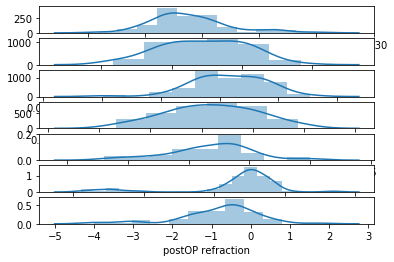

In [6]:
f, axes = plt.subplots(len(df.columns), 1)

for col,ax in zip(df.columns,axes):
    sns.distplot(df[col],ax=ax)

# Haigis公式

这里从文献的引言部分讲起, 请参考[原文](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0158988#sec001)

Haigis公式
$$
D=\frac{n}{L-d}-\frac{n}{\frac{R_{x}}{K_{m}+\frac{R_{x}}{1-R_{x} \cdot 0.012 m}}-d} \tag{1}
$$

是基于一个简化的角膜薄透镜模型，该模型仅使用角膜前表面的角膜曲率值来计算有效角膜屈光力 Km，使用 nc = 1.332的平均角膜屈光指数进行计算。 

* Rx是计划屈光度。
* 术后光学前房深度 d 不一定与术后生理性前房深度相对应。
* 房水的折射率n = 1.336，
* ACD是有晶体眼时的前房深度，
* L是眼轴长度

**预测**的光学前房深度d，由下面公式给出：
$$
d=a_{0}+A C D \cdot a_{1}+L \cdot a_{2} \tag{2}
$$

其中Haigis公式中的a0,a1,a2是IOL型号特异性的，每个厂家每种型号不一定相同。

术后**实际**光学前房深度可通过求解方程 1 的 d，推导得出, 将方程 1 中计划的屈光度 Rx 替换为术后实际的屈光度 F。 
$$
z=K_{m}+\frac{F}{1-F \cdot 0.012 \mathrm{m}} \tag{3}
$$

得到化简的方程1

$$
d=\frac{1}{2}\left(L+\frac{n}{z}\right)-\sqrt{\frac{1}{4}\left(L+\frac{n}{z}\right)^{2}-\left(L \frac{n}{z}-\frac{n^{2}}{D z}+n \frac{L}{D}\right)} \tag{4}
$$

方程4得到的d，应该和方程2得到的d之间误差尽量小，所谓优化参数，就是找到合适的$a_{0},a_{1},a_{2}$, 使得方程4-方程2的平方和最小

$$
\chi_{\mathrm{olsq}}^{2}=\sum_{i}\left(a_{0}+A C D_{i} \cdot a_{1}+L_{i} \cdot a_{2}-d_{i}\right)^{2}
$$



# 线性回归

其实上面就是个线性回归的问题，也就是求解 Y = K X + b

todo：
用PyMC的效果似乎不好，换个优化器，可能lmfit就比较合适，而且通用。

In [7]:
from lmfit import Minimizer, Parameters, report_fit

In [8]:
def d_est(n, nc, L,D1,D2,ACD,F,D):
    mean_D=(D1+D2)/2
    Km=(nc-1)/mean_D
    z=Km+F/(1-F*0.012)
    d=1/2*(L+n/z)-np.sqrt(
        1/4*(L+n/z)**2 -
        (L*n/z - n**2/(D*z) + n*L/D)
    )
    return d
df['d']=df.apply(lambda row: 
                 d_est(n=1.336, nc=1.332, L=row.AL, D1=row.D1, D2=row.D2, ACD=row.ACD, F=row["postOP refraction"],D=row['IOL power']),
                 axis=1)

In [9]:
def fcn2min(params, ACD,L, d):
    """Model a decaying sine wave and subtract data."""
    a0 = params['a0']
    a1 = params['a1']
    a2 = params['a2']
    loss = (a0+ACD*a1+L*a2 -d )**2
    return loss


# create a set of Parameters
params = Parameters()
params.add('a0', value=1.1)
params.add('a1', value=0.4)
params.add('a2', value=0.1)

In [10]:
# do fit, here with leastsq model
minner = Minimizer(fcn2min, params, fcn_args=(df.ACD,df.AL,df.d))
result = minner.minimize()

# calculate final result
final = df.d + result.residual

# write error report
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 89
    # data points      = 69
    # variables        = 3
    chi-square         = 8.7891e-12
    reduced chi-square = 1.3317e-13
    Akaike info crit   = -2042.72109
    Bayesian info crit = -2036.01877
[[Variables]]
    a0:  0.00230851 +/- 9.6876e-04 (41.96%) (init = 1.1)
    a1:  0.39175618 +/- 0.15772149 (40.26%) (init = 0.4)
    a2:  0.07276687 +/- 0.05394929 (74.14%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a2) = -0.942
    C(a1, a2) = -0.782
    C(a0, a1) =  0.530


In [11]:
from IOL_formulas import Haigis
# (R,AC,L,Dl=None, Rx=None, A=None, a0=None,a1=0.400,a2=0.100)

In [12]:
def fcn2min(params,R, AC, L,Dl, PostOP_Rx):
    """Model a decaying sine wave and subtract data."""
    a0 = params['a0']
    a1 = params['a1']
    a2 = params['a2']
    
    Rx=Haigis(R=R,AC=AC,L=L,Dl=Dl,a0=a0,a1=a1,a2=a2)
    
    
    loss = (Rx-PostOP_Rx )**2
    return loss
# create a set of Parameters
params = Parameters()
params.add('a0', value=1.1)
params.add('a1', value=0.4)
params.add('a2', value=0.1)

In [15]:
# do fit, here with leastsq model
minner = Minimizer(fcn2min, params, 
                   fcn_args=(
                       (df.D1+df.D2)/2 * 1000,
                       df.ACD * 1000,
                       df.AL * 1000,
                       df["IOL power"],
                       df["postOP refraction"])
                  )
result = minner.minimize()

# write error report
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 69
    # variables        = 3
    chi-square         = 35.0406708
    reduced chi-square = 0.53091925
    Akaike info crit   = -40.7541995
    Bayesian info crit = -34.0518800
[[Variables]]
    a0:  10.1253329 +/- 1.86890113 (18.46%) (init = 1.1)
    a1: -0.02132991 +/- 0.28369618 (1330.04%) (init = 0.4)
    a2: -0.23932645 +/- 0.09883911 (41.30%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a2) = -0.937
    C(a1, a2) = -0.658
    C(a0, a1) =  0.356


In [16]:
df.columns

Index(['AL', 'D1', 'D2', 'ACD', 'IOL power', 'target refraction',
       'postOP refraction', 'd'],
      dtype='object')

In [27]:
df["opIOL"]=df.apply(lambda row: 
                     Haigis(
                       R=(row.D1+row.D2)/2 * 1000,
                       AC=row.ACD * 1000,
                       L=row.AL * 1000,
                       Rx=row['target refraction'],
                       a0=10.1253329, a1=-0.02132991,a2=-0.23932645),
                     axis=1)
df['opRef']=df.apply(lambda row:
                    Haigis(
                       R=(row.D1+row.D2)/2 * 1000,
                       AC=row.ACD * 1000,
                       L=row.AL * 1000,
                       Dl=row["opIOL"], 
                       a0=10.1253329, a1=-0.02132991,a2=-0.23932645),
                     axis=1)
df['calRef']=df.apply(lambda row:
                    Haigis(
                       R=(row.D1+row.D2)/2 * 1000,
                       AC=row.ACD * 1000,
                       L=row.AL * 1000,
                       Dl=row["IOL power"], 
                       a0=10.1253329, a1=-0.02132991,a2=-0.23932645),
                     axis=1)
                         
                         
#                          R,AC,L,Dl=None, Rx=None, A=None, a0=None,a1=0.400,a2=0.100

In [28]:
df

,AL,D1,D2,ACD,IOL power,target refraction,postOP refraction,d,opIOL,opRef,calRef
0,0.02497,0.00715,0.00704,0.00357,16.5,-2.50,-4.00,0.005565,12.721231,-1.160096,-2.566951
1,0.02162,0.00780,0.00759,0.00249,29.0,-0.99,-0.75,0.004656,30.108607,-0.483823,-0.092684
2,0.02653,0.00806,0.00789,0.00394,17.5,-2.73,-3.25,0.005309,14.883433,-1.344629,-2.442837
3,0.02203,0.00751,0.00744,0.00274,25.5,-0.48,-0.50,0.004843,25.446418,-0.231830,-0.250367
4,0.02305,0.00799,0.00788,0.00294,25.0,-0.69,-0.25,0.005105,24.428522,-0.343122,-0.556902
5,0.02274,0.00757,0.00747,0.00313,23.0,-0.28,0.25,0.005428,22.099962,-0.135821,-0.453865
6,0.02661,0.00842,0.00827,0.00387,16.5,-0.68,-1.50,0.004548,14.501535,-0.346733,-1.180945
7,0.02423,0.00737,0.00732,0.00333,17.5,-0.58,-1.00,0.005635,14.958795,-0.277416,-1.197938
8,0.02401,0.00808,0.00796,0.00324,22.0,-0.35,-0.25,0.005184,20.586728,-0.175334,-0.717469
9,0.02326,0.00738,0.00732,0.00316,21.0,-0.83,-0.50,0.005754,19.157604,-0.396516,-1.052089


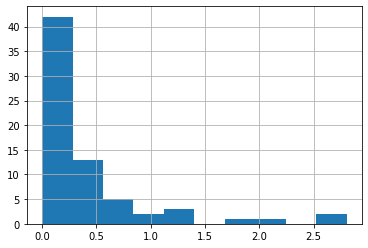

In [20]:
pd.Series(result.residual).hist()